Nama : Rully Lukas T

NIM : 1103200181

Kelas : Machine Learning

Tugas 10 Neural Network D2L

Link Dataset : https://d2l.ai/chapter_multilayer-perceptrons/kaggle-house-price.html

# Instalasi dan Memuat Library

In [ ]:
!pip install d2l

Program di atas bertujuan untuk membantu pengguna mengunduh dan menginstal paket d2l, yang merupakan sebuah buku daring tentang pembelajaran mesin dan pembelajaran mendalam. Dengan menginstal paket ini, pengguna dapat menggunakan fungsi-fungsi dan modul-modul yang disediakan dalam buku tersebut secara langsung di lingkungan pengembangan Python mereka.

In [ ]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l


Kode di atas mengatur matplotlib agar output plot ditampilkan secara langsung di notebook. Kemudian, itu mengimpor modul pandas untuk manipulasi data, serta modul torch untuk komputasi tensor menggunakan PyTorch. Modul torch.nn diimpor untuk pembuatan model neural network, dan d2l.torch diimpor dari paket d2l untuk fungsi-fungsi tambahan yang berkaitan dengan PyTorch dalam buku "Dive into Deep Learning".

# Mengunduh Data

In [ ]:
def download(url, folder, sha1_hash=None):
    """Download a file to folder and return the local filepath."""

def extract(filename, folder):
    """Extract a zip/tar file into folder."""

Fungsi download mendownload sebuah file dari URL yang diberikan dan menyimpannya di folder yang ditentukan. Fungsi ini kemudian mengembalikan jalur file lokal tempat file tersebut disimpan.

Fungsi extract mengekstrak file zip/tar yang diberikan ke dalam folder yang ditentukan.

# Mengakses dan Membaca Dataset

In [ ]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

Dalam kode di atas, terdapat definisi kelas KaggleHouse yang merupakan turunan dari d2l.DataModule. Kelas ini memiliki metode __init__ yang digunakan untuk inisialisasi objek kelas.

- Di dalam metode __init__, super().__init__() dipanggil untuk memanggil metode inisialisasi dari kelas induk, yaitu d2l.DataModule.

- self.save_hyperparameters() digunakan untuk menyimpan semua argumen yang dilewatkan ke konstruktor sebagai atribut objek. Ini berguna untuk menyimpan hyperparameter dan kemudian dapat diakses di tempat lain dalam kelas.

- Jika argumen train tidak diberikan saat pembuatan objek, maka data latih dan data validasi akan diunduh. Data tersebut diunduh menggunakan fungsi download dari modul d2l dengan URL yang ditentukan dan disimpan di direktori yang ditentukan juga.

In [ ]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


Kode yang diberikan akan menghasilkan dimensi dari data latih (raw_train) dan data validasi (raw_val) yang telah diunduh. Ini akan mencetak jumlah baris (instances) dan kolom (features) dari kedua dataset tersebut. Sebagai contoh:

**Output :**

Ini menunjukkan bahwa data latih memiliki 1460 baris dan 81 kolom, sementara data validasi memiliki 1459 baris dan 80 kolom. Biasanya, kolom terakhir di data latih adalah target atau variabel yang akan diprediksi.

# Pra-Prosesan Data

In [ ]:
print(data.raw_train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


Perintah ini akan mencetak empat baris pertama dari data latih (raw_train) beserta kolom-kolom yang dipilih. Pemilihan kolom dilakukan dengan menggunakan indeks kolom, di mana [0, 1, 2, 3, -3, -2, -1] menunjukkan indeks kolom dari 0 hingga 3 (kolom pertama hingga keempat), dan indeks negatif menunjukkan indeks kolom dari belakang (dimulai dari -1 untuk kolom terakhir, -2 untuk kolom kedua dari belakang, dan seterusnya).

**Output :**

Output yang Anda berikan menampilkan empat baris pertama dari data latih, beserta beberapa kolom yang dipilih:

- Kolom pertama adalah "Id", yang merupakan identifikasi unik untuk setiap rumah.
- Kolom kedua adalah "MSSubClass", yang merupakan kode kategori yang menggambarkan tipe rumah.
- Kolom ketiga adalah "MSZoning", yang merupakan zona zonasi untuk setiap rumah.
- Kolom keempat adalah "LotFrontage", yang merupakan panjang jalan masuk ke rumah.
- Kolom kelima dari belakang adalah "SaleType", yang merupakan jenis penjualan rumah.
- Kolom keempat dari belakang adalah "SaleCondition", yang merupakan kondisi penjualan rumah.
- Kolom terakhir adalah "SalePrice", yang merupakan harga penjualan rumah.

Ini adalah contoh beberapa kolom dan baris pertama dari dataset yang mungkin digunakan dalam proyek prediksi harga rumah, di mana fitur-fitur seperti zona zonasi, luas tanah, dan jenis penjualan dapat mempengaruhi harga penjualan rumah.

In [ ]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes!='object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

Dalam kode yang Anda berikan, terdapat fungsi preprocess yang ditambahkan ke dalam kelas KaggleHouse menggunakan dekorator @d2l.add_to_class(KaggleHouse). Fungsi preprocess ini melakukan beberapa langkah pra-pemrosesan data:

Menghapus kolom "Id" dan kolom target "SalePrice" dari data latih (raw_train) dan data validasi (raw_val).
Melakukan standarisasi pada fitur-fitur numerik dengan mengurangkan rata-rata dan membaginya dengan standar deviasi.
Mengganti nilai yang hilang pada fitur-fitur numerik dengan nilai 0.
Mengganti fitur-fitur kategorikal dengan enkoding one-hot.
Menyimpan hasil pra-pemrosesan ke dalam atribut train dan val dari objek KaggleHouse, yang mewakili data latih dan data validasi setelah pra-pemrosesan.
Ini adalah prosedur umum pra-pemrosesan data yang sering digunakan sebelum memasukkan data ke dalam model pembelajaran mesin. Langkah-langkah ini membantu dalam meningkatkan kualitas dan keberlanjutan model yang akan dibangun.

In [ ]:
data.preprocess()
data.train.shape

(1460, 331)

Setelah menjalankan metode preprocess pada objek data, outputnya adalah (1460, 331). Ini menunjukkan bahwa data latih setelah proses pra-pemrosesan memiliki 1460 baris (instances) dan 331 kolom (features).

Langkah-langkah pra-pemrosesan yang dilakukan, seperti standarisasi fitur numerik, penggantian nilai yang hilang, dan enkoding one-hot pada fitur kategorikal, telah menghasilkan penambahan fitur-fitur baru dan mungkin mengubah dimensi dataset. Oleh karena itu, jumlah kolom telah meningkat menjadi 331 setelah proses pra-pemrosesan.

# Ukuran Kesalahan

In [ ]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values.astype(float),
                                      dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

Dekorator @d2l.add_to_class(KaggleHouse) digunakan di sini untuk menambahkan metode get_dataloader ke dalam kelas KaggleHouse. Metode ini bertujuan untuk menghasilkan data loader (pengisi data) yang dapat digunakan untuk melatih atau menguji model.

Penjelasan mengenai metode get_dataloader:

- Metode ini menerima parameter train, yang menentukan apakah dataloader yang dihasilkan akan digunakan untuk data latih (True) atau data validasi (False).
- Metode ini memilih data yang akan digunakan berdasarkan nilai dari parameter train.
- Jika label target ('SalePrice') tidak ada dalam data yang dipilih, metode akan mengembalikan None.
- Metode ini mengonversi data ke dalam tensor PyTorch dengan menggunakan lambda function get_tensor. Fitur-fitur diubah menjadi tensor float32, sementara target (harga rumah) diubah menjadi tensor float32 dan diambil logaritman.
- Setelah data diubah ke dalam bentuk tensor, metode get_tensorloader dari kelas KaggleHouse dipanggil untuk membuat data loader dari tensor-tensor tersebut, yang kemudian dikembalikan.

Dengan menggunakan metode ini, kita dapat dengan mudah mendapatkan data loader untuk data latih atau data validasi dari objek KaggleHouse.

# K-Fold Cross Validation

In [ ]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets


Fungsi k_fold_data yang diberikan bertujuan untuk membagi data latih menjadi k lipatan (folds) untuk validasi silang. Ini dilakukan dengan membagi data latih menjadi k bagian yang sama besar, dan kemudian menggunakan setiap bagian secara bergantian sebagai data validasi sementara yang lainnya digunakan sebagai data latih. Setiap iterasi dari fungsi ini mengembalikan k objek KaggleHouse, masing-masing mewakili satu lipatan dari data untuk validasi silang.

Penjelasan lebih lanjut tentang fungsi k_fold_data:

- Fungsi ini menerima dua argumen, yaitu data yang merupakan objek KaggleHouse yang berisi data latih, dan k yang merupakan jumlah lipatan yang diinginkan untuk validasi silang.
- Fungsi ini membagi data latih menjadi lipatan dengan ukuran yang sama (fold_size), dengan jumlah total lipatan sama dengan k.
- Dalam setiap iterasi, sebuah objek KaggleHouse baru dibuat untuk setiap lipatan. Data latih dari lipatan saat ini dihilangkan dari data latih baru, sedangkan lipatan saat ini digunakan sebagai data validasi.
- Setiap objek KaggleHouse baru yang dibuat disimpan dalam sebuah daftar rets.
- Setelah iterasi selesai, daftar rets yang berisi objek-objek KaggleHouse untuk setiap lipatan dikembalikan sebagai output dari fungsi.

Dengan menggunakan fungsi ini, kita dapat mempersiapkan data untuk validasi silang dengan mudah dan kemudian menggunakan lipatan-lipatan tersebut untuk melatih dan menguji model secara berulang-ulang.

In [ ]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

Fungsi k_fold yang diberikan bertujuan untuk melatih model menggunakan validasi silang k-fold. Ini dilakukan dengan menggunakan objek trainer untuk melatih model pada setiap lipatan dari data dan mengukur kerugian pada data validasi. Setelah validasi silang selesai, fungsi ini mengembalikan model-model yang dilatih dan rata-rata kerugian validasi pada semua lipatan.

Penjelasan lebih lanjut tentang fungsi k_fold:

- Fungsi ini menerima empat argumen, yaitu trainer yang merupakan objek untuk melatih model, data yang merupakan objek KaggleHouse yang berisi data, k yang merupakan jumlah lipatan untuk validasi silang, dan lr yang merupakan tingkat pembelajaran (learning rate).
- Fungsi ini menggunakan fungsi k_fold_data untuk membagi data latih menjadi k lipatan.
- Selama iterasi melalui setiap lipatan dari data, sebuah model regresi linear baru dibuat dan dilatih menggunakan objek trainer.fit.
- Setelah pelatihan selesai, kerugian validasi pada model yang dilatih dievaluasi dan disimpan dalam daftar val_loss.
- Model-model yang dilatih dan kerugian validasi yang dihitung kemudian dikembalikan sebagai output dari fungsi, bersama dengan rata-rata kerugian validasi pada semua lipatan.

Dengan menggunakan fungsi ini, kita dapat melakukan validasi silang k-fold dengan mudah dan mendapatkan model-model yang dilatih serta evaluasi performanya pada setiap lipatan.

# Seleksi Model

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functi

average validation log mse = 0.17597740590572358


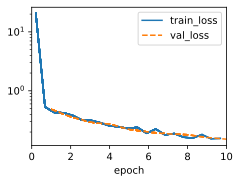

In [ ]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

Kode yang Anda berikan menginisialisasi objek trainer dari modul d2l dengan max_epochs=10, yang akan digunakan untuk melatih model. Selanjutnya, fungsi k_fold dipanggil dengan menggunakan trainer, objek data yang berisi data latih, jumlah lipatan (k) sebanyak 5, dan tingkat pembelajaran (lr) sebesar 0.01.

Setelah menjalankan fungsi k_fold, kita akan mendapatkan model-model yang telah dilatih dan rata-rata kerugian validasi dari semua lipatan. Model-model tersebut dapat digunakan untuk prediksi di kemudian hari, sedangkan rata-rata kerugian validasi memberikan gambaran tentang performa rata-rata model pada setiap lipatan validasi.

# Prediksi pada Kaggle

In [ ]:
preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)

Kode tersebut digunakan untuk membuat prediksi harga rumah menggunakan model-model yang telah dilatih pada setiap lipatan dari validasi silang. Prediksi-prediksi tersebut kemudian disatukan dan dirata-ratakan untuk mendapatkan prediksi ensemble. Hasil prediksi tersebut kemudian disimpan dalam format CSV untuk pengiriman atau evaluasi lebih lanjut.

Berikut adalah penjelasan langkah-langkah dalam kode tersebut:

- Loop for digunakan untuk melakukan prediksi pada setiap model yang telah dilatih, dan hasil prediksi dimasukkan ke dalam list preds.
- Kemudian, prediksi-prediksi tersebut diubah kembali dari skala logaritma ke skala asli dengan mengambil eksponensiasi dari nilai-nilai tersebut.
- Prediksi-prediksi tersebut kemudian disatukan menggunakan fungsi torch.cat dan dirata-ratakan menggunakan torch.mean(1) untuk mendapatkan prediksi ensemble.
- Hasil prediksi tersebut kemudian dibuat menjadi sebuah DataFrame menggunakan objek pd.DataFrame, dan disimpan dalam format CSV dengan nama file 'submission.csv' tanpa menyertakan indeks.

File 'submission.csv' yang dihasilkan akan berisi kolom 'Id' yang sesuai dengan data validasi awal dan kolom 'SalePrice' yang berisi prediksi harga rumah. File ini dapat digunakan untuk mengirimkan prediksi Anda atau untuk evaluasi lebih lanjut.